# 通用参数

In [1]:
max_len = 512

# 分词器

In [2]:
from transformers import AutoTokenizer

tokenizer_path = "/data/homework0/models/Llama-2-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
tokenizer.pad_token_id =tokenizer.eos_token_id
tokenizer.pad_token =tokenizer.eos_token

# 数据预处理

In [3]:
from datasets import Dataset

def process_data(data_path, tokenizer, max_len):
    def process_single_data(single_data):
        text = "Context: " + single_data["context"] + " Question: " + single_data["question"]

        for index, option in enumerate(single_data["answers"]):
            text += " Option " + chr(index + 65) + ": " + option
        
        single_data = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=max_len)
        single_data['input_ids'] = single_data['input_ids'].squeeze(0)
        single_data['attention_mask'] = single_data['attention_mask'].squeeze(0)
        return single_data

    data = Dataset.from_json(data_path)
    data = data.map(process_single_data,  num_proc=8, remove_columns=["context", "question", "answers", "id_string"])
    data.set_format("torch")
    return data

In [4]:
train_dataset_path = "./reclor_data/train.json"
train_dataset = process_data(train_dataset_path, tokenizer, max_len)
val_dataset_path = "./reclor_data/val.json"
val_dataset = process_data(val_dataset_path, tokenizer, max_len)
test_dataset_path = "./reclor_data/test.json"
test_dataset = process_data(test_dataset_path, tokenizer, max_len)

In [5]:
print(type(train_dataset))
print(tokenizer.decode(train_dataset[0]["input_ids"]))

# train_dataset = train_dataset.select([1, 2, 3, 4, 5, 6, 7, 8, 9])
# val_dataset = val_dataset.select([1, 2, 3, 4, 5, 6, 7, 8, 9])

<class 'datasets.arrow_dataset.Dataset'>
<s> Context: In rheumatoid arthritis, the body' s immune system misfunctions by attacking healthy cells in the joints causing the release of a hormone that in turn causes pain and swelling. This hormone is normally activated only in reaction to injury or infection. A new arthritis medication will contain a protein that inhibits the functioning of the hormone that causes pain and swelling in the joints. Question: The statements above, if true, most strongly support which one of the following conclusions? Option A: Unlike aspirin and other medications that reduce pain and swelling and that are currently available, the new medication would repair existing cell damage that had been caused by rheumatoid arthritis. Option B: A patient treated with the new medication for rheumatoid arthritis could sustain a joint injury without becoming aware of it. Option C: Joint diseases other than rheumatoid arthritis would not be affected by the new medication. Op

## 计算一下各类权重，用于之后的损失计算

In [6]:
option0_weights = len(train_dataset.to_pandas()) / (4 * train_dataset.to_pandas().label.value_counts()[0])
option1_weights = len(train_dataset.to_pandas()) / (4 * train_dataset.to_pandas().label.value_counts()[1])
option2_weights = len(train_dataset.to_pandas()) / (4 * train_dataset.to_pandas().label.value_counts()[2])
option3_weights = len(train_dataset.to_pandas()) / (4 * train_dataset.to_pandas().label.value_counts()[3])
print(option0_weights, option1_weights, option2_weights, option3_weights)

0.9901793339026473 0.9910256410256411 1.0047660311958406 1.0144356955380578


## 数据整理器

将所有数据统一填充至 batch 内最长序列的长度

In [7]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 基座大语言模型

In [8]:
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import torch

llama_path = "/data/homework0/models/Llama-2-7b-hf"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

llama_model = AutoModelForSequenceClassification.from_pretrained(
    llama_path,
    num_labels=4,                       # 每个题目有四个选项
    offload_folder="offload",
    quantization_config=quant_config, 
    device_map={"": 4},
    use_cache=False
)

llama_model.config.pad_token_id = llama_model.config.eos_token_id

/data/homework0/anaconda3/envs/wyt/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:107: UserWarning: 

BNB_CUDA_VERSION=XXX can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64
Loading CUDA version: BNB_CUDA_VERSION=117


  warn((f'\n\n{"="*80}\n'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/data/homework0/anaconda3/envs/wyt/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /data/homework0/models/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
print(f'memory usage of model: {llama_model.get_memory_footprint() / (1024 * 1024 * 1024):.2} GB')

memory usage of model: 3.3 GB


# LoRA设置

## 找到需要Lora finetune的Module Names

In [10]:
import bitsandbytes as bnb

lora_module_names = set()
for name, module in llama_model.named_modules():
    if isinstance(module, bnb.nn.Linear4bit):
        names = name.split('.')
        lora_module_names.add(names[0] if len(names) == 1 else names[-1])


if 'lm_head' in lora_module_names: # needed for 16-bit or 32-bit
    lora_module_names.remove('lm_head')

list(lora_module_names)

['v_proj', 'gate_proj', 'up_proj', 'o_proj', 'down_proj', 'q_proj', 'k_proj']

In [11]:
target_modules = list(lora_module_names)
# target_modules = ["q_proj", "v_proj"]

from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
llama_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=16, lora_alpha=16, lora_dropout=0.05, bias="none",
    target_modules=target_modules,
)

llama_model = prepare_model_for_kbit_training(llama_model) 
llama_model = get_peft_model(llama_model, llama_peft_config)
llama_model.print_trainable_parameters()

trainable params: 39,993,344 || all params: 6,647,353,344 || trainable%: 0.6016


# 自定义Trainer

In [12]:
import numpy as np
from transformers import TrainingArguments, Trainer

device = "cuda:4"

llama_model = llama_model.to(device)

from transformers import Trainer

class WeightedCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Get model's predictions
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([option0_weights, option1_weights, option2_weights, option3_weights], device=labels.device, dtype=logits.dtype))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


from datasets import load_metric

# 加载预定义的指标，例如准确率
accuracy_metric = load_metric('accuracy')
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric= load_metric("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"precision": precision, "recall": recall, "f1-score": f1, 'accuracy': accuracy}

/tmp/ipykernel_8844/3241545351.py:25: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric('accuracy')


# 废弃的训练过程

In [13]:
# lr = 1e-4
# batch_size = 2
# num_epochs = 3

# training_args = TrainingArguments(
#     output_dir="./llama_lora_output",
#     do_train=True,
#     do_eval=True,
#     learning_rate=lr,
#     lr_scheduler_type= "constant",
#     warmup_ratio= 0.1,
#     max_grad_norm= 0.3,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=num_epochs,
#     weight_decay=0.001,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     report_to="wandb",
#     fp16=True,
#     logging_steps=25,
#     save_steps=0,
#     gradient_checkpointing=True,
# )

# llama_trainer = Trainer(
#     compute_metrics=compute_metrics,
#     model=llama_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     data_collator=data_collator,
# )

# llama_trainer.train()

# 训练

In [14]:
from tqdm import tqdm
from torch.utils.data import DataLoader

lr = 1e-4
batch_size = 1
num_epochs = 3

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=data_collator, batch_size=batch_size, pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset, collate_fn=data_collator, batch_size=batch_size, pin_memory=True
)


optimizer = torch.optim.AdamW(params=llama_model.parameters(), lr=lr)

def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    # Get model's predictions
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # Compute custom loss
    loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([option0_weights, option1_weights, option2_weights, option3_weights], device=labels.device, dtype=logits.dtype))
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [15]:
train_hishory_loss = []
eval_hishory_loss = []
accuracy_history = []

In [19]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True 

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    print("⬇️" * 30)
    llama_model.train()
    total_train_loss = 0
    for index, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} while training")):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        loss = compute_loss(llama_model, batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.detach().float().cpu()
    
        if (index+1) % 400 == 0:
            avg_loss = total_train_loss / len(train_dataloader)
            train_hishory_loss.append(avg_loss.cpu())
            print(f"\nAverage Loss: {avg_loss}\n")

            print("❤️" * 30)

            llama_model.eval()
            eval_total_loss = 0
            right_num = 0
            with torch.no_grad():
                torch.cuda.empty_cache()
                for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1} while evaluating"):
                    batch = {k: v.to(device) for k, v in batch.items()}

                    labels = batch.pop("labels")
                    outputs = llama_model(**batch)
                    logits = outputs.get("logits")

                    loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([option0_weights, option1_weights, option2_weights, option3_weights], device=labels.device, dtype=logits.dtype))
                    loss = loss_fct(logits.view(-1, llama_model.config.num_labels), labels.view(-1))
                    eval_total_loss += loss.detach().float().cpu()

                    preds = logits.argmax(-1)
                    right_num += torch.eq(labels, preds).sum().detach().float().cpu()


                avg_loss = eval_total_loss / len(val_dataloader)
                eval_hishory_loss.append(avg_loss.cpu())
                accuracy = right_num / len(val_dataloader)
                accuracy_history.append(accuracy.cpu())
                print(f"\nAverage Loss: {avg_loss}\nAccuracy: {accuracy}\n")

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️


Epoch 1 while training:   0%|          | 0/4638 [00:00<?, ?it/s]

Epoch 1 while training:   9%|▊         | 399/4638 [06:31<1:06:48,  1.06it/s]


Average Loss: 0.011243651621043682

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:   9%|▊         | 400/4638 [09:18<59:38:18, 50.66s/it]


Average Loss: 1.5073559284210205
Accuracy: 0.6140000224113464



Epoch 1 while training:  17%|█▋        | 799/4638 [13:49<41:14,  1.55it/s]   


Average Loss: 0.027030501514673233

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  17%|█▋        | 800/4638 [16:36<53:46:38, 50.44s/it]


Average Loss: 1.9693115949630737
Accuracy: 0.5920000076293945



Epoch 1 while training:  26%|██▌       | 1199/4638 [21:08<38:52,  1.47it/s]  


Average Loss: 0.044439397752285004

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  26%|██▌       | 1200/4638 [23:55<48:19:26, 50.60s/it]


Average Loss: 1.3283281326293945
Accuracy: 0.6060000061988831



Epoch 1 while training:  34%|███▍      | 1599/4638 [28:30<35:27,  1.43it/s]   


Average Loss: 0.05838685855269432

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  34%|███▍      | 1600/4638 [31:16<42:34:31, 50.45s/it]


Average Loss: 1.6554234027862549
Accuracy: 0.5899999737739563



Epoch 1 while training:  43%|████▎     | 1999/4638 [35:48<26:56,  1.63it/s]   


Average Loss: 0.08245214819908142

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  43%|████▎     | 2000/4638 [38:34<36:44:18, 50.14s/it]


Average Loss: 1.252241611480713
Accuracy: 0.6200000047683716



Epoch 1 while training:  52%|█████▏    | 2399/4638 [43:07<24:18,  1.54it/s]   


Average Loss: 0.10256977379322052

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  52%|█████▏    | 2400/4638 [45:53<31:18:32, 50.36s/it]


Average Loss: 1.1830792427062988
Accuracy: 0.5839999914169312



Epoch 1 while training:  60%|██████    | 2799/4638 [50:23<19:59,  1.53it/s]   


Average Loss: 0.12030235677957535

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  60%|██████    | 2800/4638 [53:10<25:43:31, 50.39s/it]


Average Loss: 1.539013385772705
Accuracy: 0.6000000238418579



Epoch 1 while training:  69%|██████▉   | 3199/4638 [57:40<15:21,  1.56it/s]   


Average Loss: 0.14189542829990387

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  69%|██████▉   | 3200/4638 [1:00:26<20:02:16, 50.16s/it]


Average Loss: 1.083541989326477
Accuracy: 0.5960000157356262



Epoch 1 while training:  78%|███████▊  | 3599/4638 [1:04:59<10:26,  1.66it/s]   


Average Loss: 0.1692158728837967

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  78%|███████▊  | 3600/4638 [1:07:45<14:30:13, 50.30s/it]


Average Loss: 1.230594515800476
Accuracy: 0.5839999914169312



Epoch 1 while training:  86%|████████▌ | 3999/4638 [1:12:17<06:57,  1.53it/s]   


Average Loss: 0.19153909385204315

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  86%|████████▌ | 4000/4638 [1:15:02<8:49:52, 49.83s/it]


Average Loss: 1.4378212690353394
Accuracy: 0.5580000281333923



Epoch 1 while training:  95%|█████████▍| 4399/4638 [1:19:28<02:34,  1.54it/s]  


Average Loss: 0.21488329768180847

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 1 while training:  95%|█████████▍| 4400/4638 [1:22:10<3:14:20, 48.99s/it]


Average Loss: 1.5436248779296875
Accuracy: 0.6000000238418579



Epoch 1 while training: 100%|██████████| 4638/4638 [1:24:47<00:00,  1.10s/it]  


⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️


Epoch 2 while training:   9%|▊         | 399/4638 [06:30<1:09:11,  1.02it/s]


Average Loss: 0.00782840233296156

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:   9%|▊         | 400/4638 [09:13<58:09:03, 49.40s/it]


Average Loss: 1.2290540933609009
Accuracy: 0.5820000171661377



Epoch 2 while training:  17%|█▋        | 799/4638 [13:41<40:30,  1.58it/s]   


Average Loss: 0.01627008430659771

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  17%|█▋        | 800/4638 [16:24<52:27:19, 49.20s/it]


Average Loss: 1.5569757223129272
Accuracy: 0.5860000252723694



Epoch 2 while training:  26%|██▌       | 1199/4638 [20:50<36:18,  1.58it/s]  


Average Loss: 0.025724558159708977

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  26%|██▌       | 1200/4638 [23:32<46:50:25, 49.05s/it]


Average Loss: 1.6531877517700195
Accuracy: 0.6039999723434448



Epoch 2 while training:  34%|███▍      | 1599/4638 [27:58<34:50,  1.45it/s]   


Average Loss: 0.03702542930841446

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  34%|███▍      | 1600/4638 [30:40<41:27:47, 49.13s/it]


Average Loss: 1.833389401435852
Accuracy: 0.578000009059906



Epoch 2 while training:  43%|████▎     | 1999/4638 [35:08<29:28,  1.49it/s]   


Average Loss: 0.05209299176931381

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  43%|████▎     | 2000/4638 [37:50<36:01:50, 49.17s/it]


Average Loss: 1.5167995691299438
Accuracy: 0.621999979019165



Epoch 2 while training:  52%|█████▏    | 2399/4638 [42:21<24:06,  1.55it/s]   


Average Loss: 0.06397450715303421

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  52%|█████▏    | 2400/4638 [45:07<31:16:25, 50.31s/it]


Average Loss: 1.637278437614441
Accuracy: 0.6119999885559082



Epoch 2 while training:  60%|██████    | 2799/4638 [49:41<20:00,  1.53it/s]   


Average Loss: 0.07307500392198563

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  60%|██████    | 2800/4638 [52:28<25:48:33, 50.55s/it]


Average Loss: 2.0591564178466797
Accuracy: 0.593999981880188



Epoch 2 while training:  69%|██████▉   | 3199/4638 [57:00<16:40,  1.44it/s]   


Average Loss: 0.0855974406003952

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  69%|██████▉   | 3200/4638 [59:45<20:04:31, 50.26s/it]


Average Loss: 1.677323818206787
Accuracy: 0.5699999928474426



Epoch 2 while training:  78%|███████▊  | 3599/4638 [1:04:16<11:28,  1.51it/s] 


Average Loss: 0.10108020156621933

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  78%|███████▊  | 3600/4638 [1:07:02<14:34:01, 50.52s/it]


Average Loss: 1.2068345546722412
Accuracy: 0.5860000252723694



Epoch 2 while training:  86%|████████▌ | 3999/4638 [1:11:39<07:19,  1.46it/s]   


Average Loss: 0.11550980806350708

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  86%|████████▌ | 4000/4638 [1:14:26<8:58:02, 50.60s/it]


Average Loss: 1.3004990816116333
Accuracy: 0.5979999899864197



Epoch 2 while training:  95%|█████████▍| 4399/4638 [1:18:58<02:42,  1.47it/s]  


Average Loss: 0.1262957602739334

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 2 while training:  95%|█████████▍| 4400/4638 [1:21:45<3:20:39, 50.59s/it]


Average Loss: 1.7457603216171265
Accuracy: 0.6019999980926514



Epoch 2 while training: 100%|██████████| 4638/4638 [1:24:27<00:00,  1.09s/it]  


⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️


Epoch 3 while training:   9%|▊         | 399/4638 [06:39<1:19:57,  1.13s/it]


Average Loss: 0.008500076830387115

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:   9%|▊         | 400/4638 [09:27<60:15:15, 51.18s/it]


Average Loss: 1.3662536144256592
Accuracy: 0.6340000033378601



Epoch 3 while training:  17%|█▋        | 799/4638 [14:03<44:23,  1.44it/s]   


Average Loss: 0.015637662261724472

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  17%|█▋        | 800/4638 [16:51<54:12:59, 50.85s/it]


Average Loss: 1.595565915107727
Accuracy: 0.621999979019165



Epoch 3 while training:  26%|██▌       | 1199/4638 [21:24<36:36,  1.57it/s]  


Average Loss: 0.024158019572496414

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  26%|██▌       | 1200/4638 [24:12<48:30:41, 50.80s/it]


Average Loss: 1.779089331626892
Accuracy: 0.5920000076293945



Epoch 3 while training:  34%|███▍      | 1599/4638 [28:46<33:40,  1.50it/s]   


Average Loss: 0.035888250917196274

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  34%|███▍      | 1600/4638 [31:33<42:39:25, 50.55s/it]


Average Loss: 2.235356092453003
Accuracy: 0.6200000047683716



Epoch 3 while training:  43%|████▎     | 1999/4638 [36:05<28:59,  1.52it/s]   


Average Loss: 0.04926202818751335

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  43%|████▎     | 2000/4638 [38:52<37:02:38, 50.55s/it]


Average Loss: 1.8553065061569214
Accuracy: 0.621999979019165



Epoch 3 while training:  52%|█████▏    | 2399/4638 [43:25<23:51,  1.56it/s]   


Average Loss: 0.05894162878394127

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  52%|█████▏    | 2400/4638 [46:13<31:28:50, 50.64s/it]


Average Loss: 1.68803870677948
Accuracy: 0.6200000047683716



Epoch 3 while training:  60%|██████    | 2799/4638 [50:45<19:35,  1.57it/s]   


Average Loss: 0.06976749002933502

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  60%|██████    | 2800/4638 [53:32<25:47:34, 50.52s/it]


Average Loss: 1.3915009498596191
Accuracy: 0.6259999871253967



Epoch 3 while training:  69%|██████▉   | 3199/4638 [58:05<16:34,  1.45it/s]   


Average Loss: 0.08192812651395798

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  69%|██████▉   | 3200/4638 [1:00:52<20:11:56, 50.57s/it]


Average Loss: 1.562265157699585
Accuracy: 0.6140000224113464



Epoch 3 while training:  78%|███████▊  | 3599/4638 [1:05:28<11:59,  1.44it/s]   


Average Loss: 0.09211317449808121

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  78%|███████▊  | 3600/4638 [1:08:14<14:32:59, 50.46s/it]


Average Loss: 1.5557631254196167
Accuracy: 0.6060000061988831



Epoch 3 while training:  86%|████████▌ | 3999/4638 [1:12:45<07:04,  1.50it/s]   


Average Loss: 0.10224395990371704

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  86%|████████▌ | 4000/4638 [1:15:30<8:51:53, 50.02s/it]


Average Loss: 1.6479778289794922
Accuracy: 0.5759999752044678



Epoch 3 while training:  95%|█████████▍| 4399/4638 [1:19:56<02:31,  1.57it/s]  


Average Loss: 0.1149977520108223

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


Epoch 3 while training:  95%|█████████▍| 4400/4638 [1:22:41<3:18:33, 50.06s/it]


Average Loss: 1.7968440055847168
Accuracy: 0.578000009059906



Epoch 3 while training: 100%|██████████| 4638/4638 [1:25:22<00:00,  1.10s/it]  


# 训练过程图像

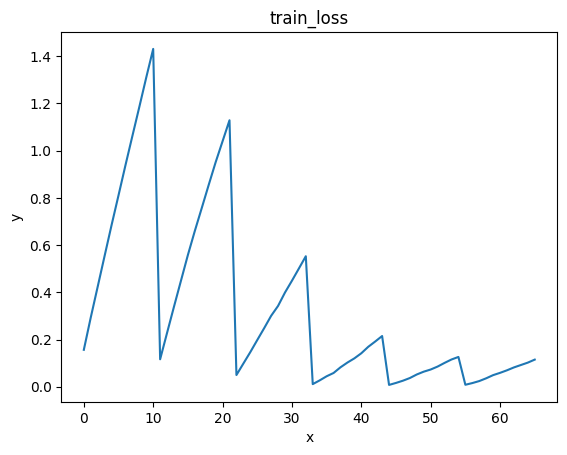

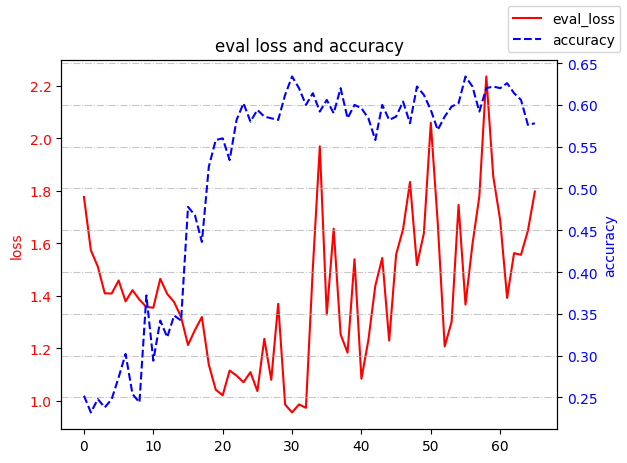

In [20]:
import matplotlib.pyplot as plt

# 绘制折线图
plt.plot(range(len(train_hishory_loss)), train_hishory_loss)

# 添加标题和坐标轴标签
plt.title("train_loss")
plt.xlabel("x")
plt.ylabel("y")
 
# 显示图表
plt.show()

fig, ax1 = plt.subplots()  # 创建一个图形和第一个 Y 轴
ax2 = ax1.twinx()  # 创建第二个 Y 轴
ax1.plot(range(len(eval_hishory_loss)), eval_hishory_loss, label='eval_loss', color="r")
ax1.set_ylabel('loss', color="r")
ax1.tick_params(axis='y', labelcolor='r')
ax2.plot(range(len(accuracy_history)), accuracy_history, ls='--', label='accuracy', color="b")
ax2.set_ylabel('accuracy', color="b")
ax2.tick_params(axis='y', labelcolor='b')
plt.title("eval loss and accuracy")
# 添加图例
fig.legend()
plt.grid(alpha=0.7, ls='-.')
# 显示图表
plt.show()

# 保存预训练模型

In [21]:
output_path = "./llama_output_new"
llama_model.save_pretrained(output_path)